## Pre-processing IMAGES

In [1]:
#importing imp. libraires
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import tensorflow_hub as hub

2024-04-05 15:54:07.995437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'Medicinal Leaf dataset',
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE,
)

NotFoundError: Could not find directory Medicinal Leaf dataset

In [4]:
class_names = dataset.class_names
class_names

NameError: name 'dataset' is not defined

In [18]:
len(dataset)

216

2024-04-03 15:32:05.245423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6900]
	 [[{{node Placeholder/_4}}]]
2024-04-03 15:32:05.245905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6900]
	 [[{{node Placeholder/_0}}]]


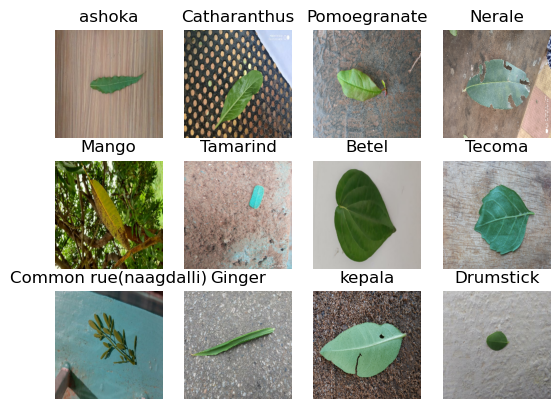

In [19]:
# Visualiasiing the DATA
for img_bth , lbl_bth in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img_bth[i].numpy().astype("uint8"))
        plt.title(class_names[lbl_bth[i]])
        plt.axis("off")

In [24]:
#Spliting the dataset for 
#Trainig 
#Validation
#Testing
train_size = 0.8
val_test_size = 0.1
print("Training Set:" ,int(len(dataset)*train_size))
print("Validation Set:" , int(len(dataset)*val_test_size))

Training Set: 172
Validation Set: 21


In [25]:
def get_data_partitions(ds, train_split=0.8, val_split=0.1 , test_split=0.1 , shuffle=True ,shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds ,val_ds , test_ds

In [26]:
train_ds , val_ds , test_ds = get_data_partitions(dataset)

In [27]:
len(train_ds)

172

In [28]:
# IN order to increse the performace of model traning we can make use of ternsor optimiseation usign cache and prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
# Data Resing and Rescaling 
rez_res = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
    
])

In [30]:
# Data Augumnetation 
# here to avoid data overfitting we can use D.A.
# I will be using 3 methods random filps , random rotation , random zoom
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3)
])

In [31]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                              mode = 'max' ,
                              patience = 8,
                              verbose = 1)


callback_list = [earlystopping]

## MODEL 1 - Using just MobileNetV2 as base model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Add custom layers for classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

# Create the final model
model = tf.keras.Sequential([
    rez_res,
    data_aug,
    base_model,
    global_average_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(104, activation='relu'),
    tf.keras.layers.Dense(96, activation='relu'),
    prediction_layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.build(input_shape = (None,IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [ ]:
model.summary()

In [ ]:
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks = callback_list)

In [ ]:
model.evaluate(test_ds)

In [ ]:
model.save("./model/mpia_mobv2.keras")

## MODEL 2 - Using efficientV2 as base model

In [37]:
model_url = "https://kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2"

efficientnet_v2_s = hub.KerasLayer(model_url,trainable=False, name='efficientnet_v2_s2')

model = tf.keras.Sequential([
    rez_res,
    efficientnet_v2_s,
    layers.Dropout(0.3),
    layers.Dense(80, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0007),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )

model.build(input_shape = (None,IMAGE_SIZE, IMAGE_SIZE, CHANNELS))



In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnet_v2_s2 (KerasLa  (None, 1000)             7200312   
 yer)                                                            
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 80)                80080     
                                                                 
Total params: 7,280,392
Trainable params: 80,080
Non-trainable params: 7,200,312
_________________________________________________________________


In [ ]:
model_history=model.fit(train_ds,
                        validation_data=val_ds,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

In [ ]:
model.evaluate(test_ds)

In [39]:
tf.keras.models.save_model(
    model,
    'path_to_save_model.h5',
    custom_objects={'KerasLayer': hub.KerasLayer}
)

TypeError: save_model() got an unexpected keyword argument 'custom_objects'

In [ ]:
model_history.history['accuracy']

## Loading Model 

Recorded acuracy for model 1 is about 0.87 and the accuracy for the model 2 is about 0.97.
Then based on their test data accuracy was 0.86 and 0.96 respectively.

In [40]:
import tensorflow as tf
import tensorflow_hub as hub

# Load the model with custom objects
model_ld = tf.keras.models.load_model(
    './model/mpia_fmod.h5',
    custom_objects={'KerasLayer': hub.KerasLayer}
)

# Compile the model if needed
model_ld.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model_ld.evaluate(test_ds)

23/23 [==============================] - 9s 406ms/step - loss: 0.1233 - accuracy: 0.9769


In [36]:
history

[0.12325114756822586, 0.976902186870575]